### **Investigação — Random forest básico** 

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.inspection import permutation_importance

**Pré-processamento dos dados**
***
* **Colunas removidas:**
    * <div style="display: flex; align-items: center; width: 75%;"><span>cod</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Número consecutivo asignado por el investigador</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>fechaingreso</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Fecha de ingreso del paciente al centro de excelencia o proyecto de investigación</span></div>
    * ...

* **Colunas codificadas para números:**
    * <div style="display: flex; align-items: center; width: 75%;"><span>fevi</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span><strong>0</strong> (x ≤ 40); <strong>1</strong> (40 < x < 50); <strong>2</strong> (x ≥ 50)</span></div>

![url/filename.gif](https://cdn.betterttv.net/emote/646d4275aee1f7f47567b314/3x.webp)

In [4]:
#Abrir dataset
df = pd.read_excel("Base_chagas.xlsx")
df = df.iloc[:-1, :]

#printar todas as variaveis para pre-processamento
resumo = pd.DataFrame({
    'tipo': df.dtypes,
    'nulos': df.isnull().sum()
})
pd.set_option('display.max_rows', None)     

#tirar colunas com fechas
df = df.drop(columns=["cod","IMC","fechaingreso", "anioingreso","Fecha aplicación","Fecha aplicación.1", "Fecha aplicación.2", "Fecha aplicación.3", "Fecha mortalidad", "Fecha trasplante", "Fecha asistencia", "Mortalidad tiempo"])
#print(df.columns)

#mudar tipo objeto para numero
df["IMCat"] = df["IMCat"].astype("category")
print(df.dtypes["IMCat"]) 
print(df["IMCat"].cat.categories)
df["IMCat"] = df["IMCat"].cat.codes

mapa = {
    "aztrazeneca": "astrazeneca",
    "covid janssen": "janssen",
    "covid pfizer": "pfizer",
    "janssen unica": "janssen",
    "modena": "moderna",
    "moderrna": "moderna",
    "nanssen": "janssen",
    "covid astrazeneca": "astrazeneca",
}

for col in ["Tipo vacuna", "Tipo vacuna.1", "Tipo vacuna.2", "Tipo vacuna.3"]:
    df[col] = (
        df[col]
        .str.strip()
        .str.lower()
        .map(lambda x: mapa.get(x, x))  # aplica mapeamento
    )

# Agora aplica one-hot para cada coluna separadamente
dummies = []
for i, col in enumerate(["Tipo vacuna", "Tipo vacuna.1", "Tipo vacuna.2", "Tipo vacuna.3"], start=1):
    dummies.append(
        pd.get_dummies(df[col], prefix=f"dose{i}")
    )

# Concatena todas as novas colunas
df = pd.concat([df] + dummies, axis=1)
df = df.drop(columns=["Tipo vacuna", "Tipo vacuna.1", "Tipo vacuna.2", "Tipo vacuna.3"])

print(df.head())

#PERGUNTAR: Precisa mesmo ter o tipo de vacina? ou a gente inclui mesmo e se não for importante descarta
print(len(df.columns))

a = pd.DataFrame({
    'tipo': df.dtypes,
    'nulos': df.isnull().sum()
})

print(a)

category
Index(['Bajo peso', 'Normal', 'Obesidad', 'Sobrepeso'], dtype='object')
   tipodepaciente  edad  sexo  estadocivil  arearesidencia  regimensalud  \
0             1.0  51.0   1.0          1.0             1.0           0.0   
1             1.0  43.0   0.0          1.0             1.0           0.0   
2             1.0  79.0   0.0          0.0             0.0           0.0   
3             1.0  62.0   1.0          1.0             1.0           1.0   
4             1.0  73.0   0.0          1.0             1.0           0.0   

   educacion  Fuma actualmente  Años de fumador  \
0        1.0               0.0              NaN   
1        1.0               0.0              NaN   
2        0.0               0.0              NaN   
3        0.0               0.0              NaN   
4        0.0               0.0              NaN   

   número de cigarrillos diarios  ...  dose3_astrazeneca  dose3_janssen  \
0                            NaN  ...              False          False   
1    

In [5]:
# transformar fevi em categorias
bins = [-float("inf"), 40, 50, float("inf")]
labels = [0, 1, 2]  # 0 = muito mal, 1 = mal, 2 = normal

df["fevi_cat"] = pd.cut(df["fevi"], bins=bins, labels=labels, right=False)

df = df.drop(columns="fevi")
# conferir
print(df["fevi_cat"].value_counts(dropna=False))

fevi_cat
0    498
2    348
1    190
Name: count, dtype: int64


In [6]:
def classificar_nt(row):
    idade = row["edad"] 
    nt = row["NT proBNP"]
    
    if pd.isnull(idade) or pd.isnull(nt):
        return np.nan
    
    if idade < 50:
        return 0 if nt < 450 else 1
    elif idade <= 75:
        return 0 if nt < 900 else 1
    else:
        return 0 if nt < 1800 else 1

df["NT proBNP_cat"] = df.apply(classificar_nt, axis=1)
df = df.drop(columns="NT proBNP")

print(df["NT proBNP_cat"].value_counts(dropna=False))

NT proBNP_cat
1.0    469
0.0    309
NaN    258
Name: count, dtype: int64


In [7]:
df["edad_cat"] = np.where(df["edad"] < 75, 0, 1)

print(df["edad_cat"].value_counts(dropna=False))
df = df.drop(columns="edad")

edad_cat
0    776
1    260
Name: count, dtype: int64


In [8]:
def classificar_fc(valor):
    if pd.isnull(valor):
        return np.nan
    elif valor >= 100:
        return 0
    elif valor >= 60:
        return 1
    else:
        return 2

df["FC_cat"] = df["FC"].apply(classificar_fc)

print(df["FC_cat"].value_counts(dropna=False))
df = df.drop(columns="FC")

FC_cat
1    865
2    127
0     44
Name: count, dtype: int64


In [9]:

def classificar_creatinina(row):
    sexo = row["sexo"]         
    creat = row["creatinina"]

    if pd.isnull(sexo) or pd.isnull(creat):
        return np.nan

    # 0->normal    1->alterado
    if sexo == 0:  # Mujer
        return 0 if creat <= 1.1 else 1
    elif sexo == 1:  # Hombre
        return 0 if creat <= 1.3 else 1
    else:
        return np.nan

df["creatinina_cat"] = df.apply(classificar_creatinina, axis=1)


print(df["creatinina_cat"].value_counts(dropna=False))
df = df.drop(columns="creatinina")

creatinina_cat
0    701
1    335
Name: count, dtype: int64


In [10]:
df["BUN_cat"] = np.where(df["BUN"] <= 20, 0,
                  np.where(df["BUN"] > 20, 1, np.nan))

print(df["BUN_cat"].value_counts(dropna=False))
df = df.drop(columns="BUN")

BUN_cat
0.0    579
1.0    457
Name: count, dtype: int64


In [11]:
df["TAPSE_cat"] = np.where(df["TAPSE"] >= 17, 0,
                   np.where(df["TAPSE"] < 17, 1, np.nan))

print(df["TAPSE_cat"].value_counts(dropna=False))
df = df.drop(columns="TAPSE")

TAPSE_cat
1.0    568
0.0    421
NaN     47
Name: count, dtype: int64


In [12]:
cols_nulos_zero = [
    "Años de fumador", "número de cigarrillos diarios", "IPA",
]
df[cols_nulos_zero] = df[cols_nulos_zero].fillna(0)

a = pd.DataFrame({
    'tipo': df.dtypes,
    'nulos': df.isnull().sum()
})

print(a)

                                                      tipo  nulos
tipodepaciente                                     float64      0
sexo                                               float64      0
estadocivil                                        float64      0
arearesidencia                                     float64      0
regimensalud                                       float64      0
educacion                                          float64      0
Fuma actualmente                                   float64      0
Años de fumador                                    float64      0
número de cigarrillos diarios                      float64      0
IPA                                                float64      0
Consumo alcohol                                    float64      0
AHA                                                float64      0
NYHA                                               float64      0
Peso                                               float64      0
Talla     

In [13]:
df = df.dropna(axis=1)

a = pd.DataFrame({
    'tipo': df.dtypes,
    'nulos': df.isnull().sum()
})

print(a)

                                     tipo  nulos
tipodepaciente                    float64      0
sexo                              float64      0
estadocivil                       float64      0
arearesidencia                    float64      0
regimensalud                      float64      0
educacion                         float64      0
Fuma actualmente                  float64      0
Años de fumador                   float64      0
número de cigarrillos diarios     float64      0
IPA                               float64      0
Consumo alcohol                   float64      0
AHA                               float64      0
NYHA                              float64      0
Peso                              float64      0
Talla                             float64      0
IMCat                                int8      0
PAS                               float64      0
Comorbilidad rxcv                 float64      0
Diabetes                          float64      0
EPOC                

In [14]:
df = df.drop(columns=["Vacunación COVID", "Primera dosis"])

In [15]:
#3 targets:
#1 - Mortalidade 2 anos
df1 = df.drop(columns=["Mortalidad", "Complicaciones total", "Complicaciones cardiovasculares"])
resumo = pd.DataFrame({
    'tipo': df1.dtypes,
    'nulos': df1.isnull().sum()
})
pd.set_option('display.max_rows', None)     
#print(resumo)

#2 - Complicações totais
df2 = df.drop(columns=["Mortalidad", "Mortalidad menor a 2 años", "Complicaciones cardiovasculares", "Trasplante", "ACV", "Asistencia"])
print(len(df2.columns))

#3 - Complicações cardiovasculares
df3 = df.drop(columns=["Mortalidad", "Mortalidad menor a 2 años", "Complicaciones total", "Trasplante", "ACV", "Asistencia"])
print(len(df3.columns))

51
51


In [16]:
def arvore(df, target):
    target_col = target
    X = df.drop(columns=[target_col])  #features
    y = df[target_col]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    importances_all = []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        if fold == 1:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

            idx, c = np.unique(y_train, return_counts=True)
            sns.barplot(x=idx, y=c, ax=ax[0], palette="viridis")
            ax[0].set_title("Distribuição antes do SMOTE")
            ax[0].set_xlabel("Classe")
            ax[0].set_ylabel("Contagem")

        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        if fold == 1:
            
            idx, c = np.unique(y_train_res, return_counts=True)
            sns.barplot(x=idx, y=c, ax=ax[1], palette="viridis")
            ax[1].set_title("Distribuição depois do SMOTE")
            ax[1].set_xlabel("Classe")
            ax[1].set_ylabel("Contagem")

            plt.tight_layout()
            plt.show()

        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train_res, y_train_res)
        
        result = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)
        importances_all.append(result.importances_mean)

        print(f"Fold {fold} concluído")

    importances_mean = np.mean(importances_all, axis=0)
    importances_std = np.std(importances_all, axis=0)

    df_importances = pd.DataFrame({
        "Feature": X.columns,
        "Mean Importance": importances_mean,
        "Std Importance": importances_std
    }).sort_values("Mean Importance", ascending=False)

    return df_importances

C:\Users\almei\AppData\Local\Temp\ipykernel_23184\307207021.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=idx, y=c, ax=ax[0], palette="viridis")
Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\almei\miniconda3\envs\chagas\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "c:\Users\almei\miniconda3\envs\chagas\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\almei\miniconda3\envs\chagas\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\almei\miniconda3\envs\chagas\Lib\subprocess.py", line 1615, in _readerthread
    buffer.append(fh.read())
              

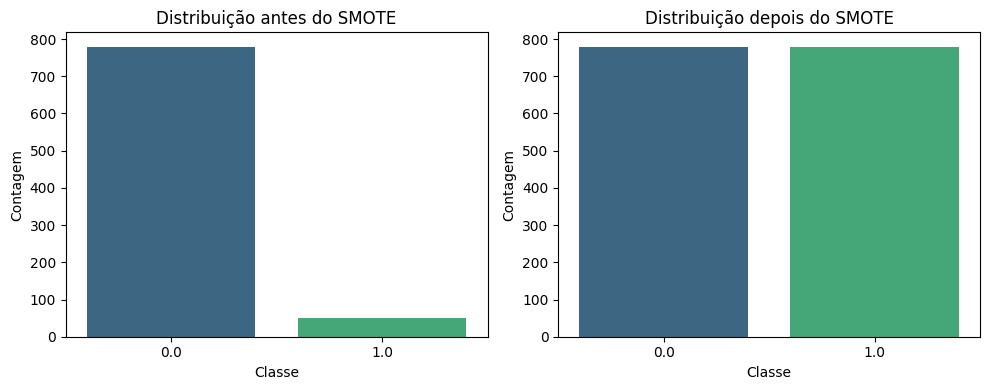

Fold 1 concluído
Fold 2 concluído
Fold 3 concluído
Fold 4 concluído
Fold 5 concluído


In [17]:
df_importances = arvore(df3, "Complicaciones cardiovasculares")

In [18]:
#==============
#Importancias
#==============
def importancias(df_importances):
    
    df_importances["Mean Importance"] = pd.to_numeric(df_importances["Mean Importance"], errors="coerce")

    df_importances = (
        df_importances
        .sort_values(by="Mean Importance", ascending=False, na_position="last")
        .reset_index(drop=True)
    )

    df_importances["Rank"] = np.arange(1, len(df_importances) + 1)

    print(df_importances.to_string(index=False))

    plt.figure(figsize=(10,5))
    plt.scatter(df_importances["Rank"], df_importances["Std Importance"], color="blue", alpha=0.7)
    plt.xlabel("Rank da Feature (1 = mais importante)")
    plt.ylabel("Desvio-padrão da importância")
    plt.title("Desvio-padrão da importância vs. Ranking")
    plt.show()

    #CART
    X_rank = df_importances["Rank"].values.reshape(-1,1)
    y_std = df_importances["Std Importance"].values

    cart = DecisionTreeRegressor(max_depth=4)
    cart.fit(X_rank, y_std)
    y_smooth = cart.predict(X_rank)

    threshold_noise = y_smooth.min()
    print("Valor mínimo:", threshold_noise)

    plt.figure(figsize=(10,5))
    plt.scatter(df_importances["Rank"], df_importances["Std Importance"], color="blue", alpha=0.5, label="Original")
    plt.plot(df_importances["Rank"], y_smooth, color="red", linewidth=2, label="CART suavizado")
    plt.xlabel("Rank da Feature (1 = mais importante)")
    plt.ylabel("Desvio-padrão da importância")
    plt.title("Suavização da curva de desvios")
    plt.axhline(y=threshold_noise, color="green", linestyle="--", label="Piso (ruído)")
    plt.legend()
    plt.show()


    noise_features = df_importances[df_importances["Mean Importance"] < threshold_noise]["Feature"].tolist()
    signal_features = df_importances[df_importances["Mean Importance"] >= threshold_noise]["Feature"].tolist()

    print("Features ruído:", noise_features)
    print("Features:", signal_features)

    return signal_features

                        Feature  Mean Importance  Std Importance  Rank
                           Peso         0.000773        0.001390     1
                            AHA         0.000676        0.001353     2
                 arearesidencia         0.000515        0.001031     3
                   dose2_pfizer         0.000419        0.000624     4
                  dose3_moderna         0.000161        0.000322     5
                   regimensalud         0.000129        0.000258     6
                           NYHA         0.000097        0.000193     7
                  dose3_sinovac         0.000064        0.000129     8
                           sexo         0.000000        0.000000     9
                 tipodepaciente         0.000000        0.000000    10
                            IPA         0.000000        0.000000    11
  número de cigarrillos diarios         0.000000        0.000000    12
                Años de fumador         0.000000        0.000000    13
      

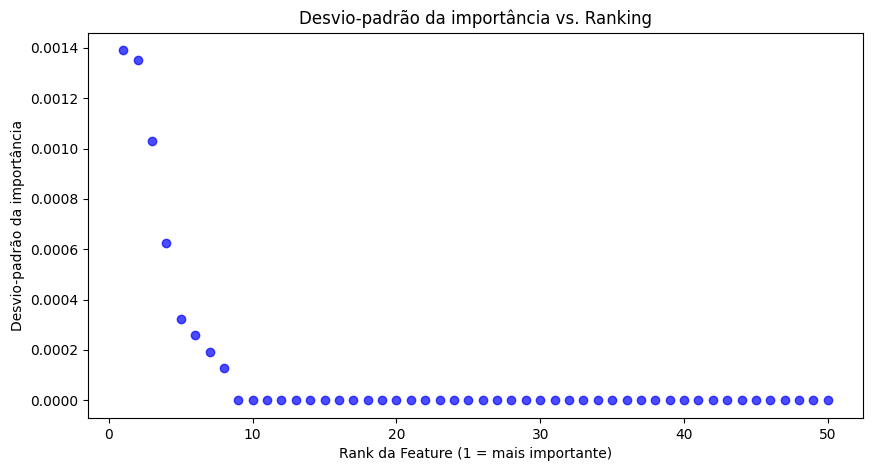

Valor mínimo: 0.0


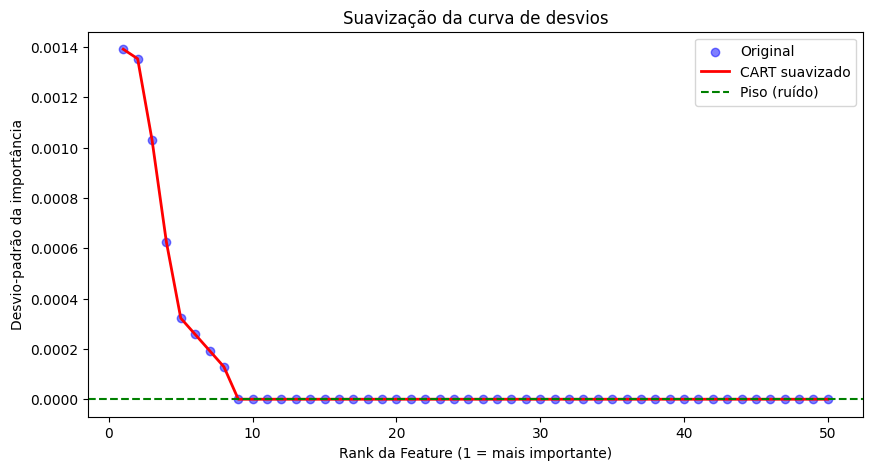

Features ruído: []
Features: ['Peso', 'AHA', 'arearesidencia', 'dose2_pfizer', 'dose3_moderna', 'regimensalud', 'NYHA', 'dose3_sinovac', 'sexo', 'tipodepaciente', 'IPA', 'número de cigarrillos diarios', 'Años de fumador', 'Consumo alcohol', 'Talla', 'Fuma actualmente', 'estadocivil', 'educacion', 'Comorbilidad rxcv', 'PAS', 'IMCat', 'Diabetes\xa0', 'Enfermedad arterial periférica\xa0', 'Hipertensión arterial\xa0', 'Fibrilación atrial', 'EPOC', 'dose1_astrazeneca', 'dose1_janssen', 'dose1_pfizer', 'dose1_moderna', 'dose1_sinovac', 'dose2_astrazeneca', 'potasio', 'Demencia (Dxco Médico)\xa0', 'dose2_moderna', 'dose2_janssen', 'dose3_astrazeneca', 'dose2_sinovac', 'dose3_janssen', 'dose3_pfizer', 'dose4_astrazeneca', 'dose4_janssen', 'dose4_moderna', 'dose4_pfizer', 'dose4_sinovac', 'fevi_cat', 'edad_cat', 'FC_cat', 'creatinina_cat', 'BUN_cat']


In [19]:
signal_features = importancias(df_importances)

In [20]:
X_candidates = df1[signal_features].values
print(X_candidates)

[[60.0 3.0 1.0 ... 1 0 1.0]
 [45.0 3.0 1.0 ... 1 1 1.0]
 [37.0 3.0 0.0 ... 1 1 1.0]
 ...
 [50.0 3.0 0.0 ... 1 0 1.0]
 [65.0 3.0 0.0 ... 2 0 1.0]
 [50.0 3.0 0.0 ... 1 1 0.0]]


In [21]:
n_repeats = 5        
n_estimators = 500    
random_state = 42

n_vars = X_candidates.shape[1]
target_col = "Complicaciones cardiovasculares"
y = df[target_col].values

errors = np.zeros((n_repeats, n_vars))

for r in range(n_repeats):
    for k in range(1, n_vars+1):
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            oob_score=True,
            bootstrap=True,
            n_jobs=-1,
            random_state=random_state + r
        )
        rf.fit(X_candidates[:, :k], y)
        errors[r, k-1] = 1 - rf.oob_score_

mean_errors = errors.mean(axis=0)
std_errors = errors.std(axis=0)

min_error = mean_errors.min()
min_index = mean_errors.argmin()

threshold = min_error + std_errors[min_index]
k_interp = np.where(mean_errors <= threshold)[0][0] + 1

print(f"Erro mínimo: {min_error:.3f} (em k={min_index+1})")
print(f"Conjunto para interpretação: usar as {k_interp} variáveis mais importantes")

interp_vars = list(range(k_interp))  

Erro mínimo: 0.060 (em k=23)
Conjunto para interpretação: usar as 20 variáveis mais importantes


In [22]:
k = k_interp
vars_k = signal_features[:k]
print(f"k={k}: {vars_k}")

k=20: ['Peso', 'AHA', 'arearesidencia', 'dose2_pfizer', 'dose3_moderna', 'regimensalud', 'NYHA', 'dose3_sinovac', 'sexo', 'tipodepaciente', 'IPA', 'número de cigarrillos diarios', 'Años de fumador', 'Consumo alcohol', 'Talla', 'Fuma actualmente', 'estadocivil', 'educacion', 'Comorbilidad rxcv', 'PAS']
